# 시계열 예측 기법

    시계열의 공통 특징
    - 트렌드: 시계열은 일반적으로 특정한 방향으로 움직임 ex) 무어의 법칙
    - 계절성: 시간에 따라 반복되는 패턴을 가짐
    - 자기상관: 어떤 이벤트 후에 예측 가능한 행동이 나타나는 것 ex) 큰 상승 곡선 -> 하락
    - 잡음: 시계열에 있는 랜덤한 변동

## 기준 성능을 위한 단순한 예측

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.metrics import MeanSquaredError

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """일정 간격마다 동일 패턴 반복"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

# 시계열 만들기
series = baseline + trend(time, slope) \
                  + seasonality(time, period=365, amplitude=amplitude)

# 잡음 추가
series += noise(time, noise_level, seed=42)

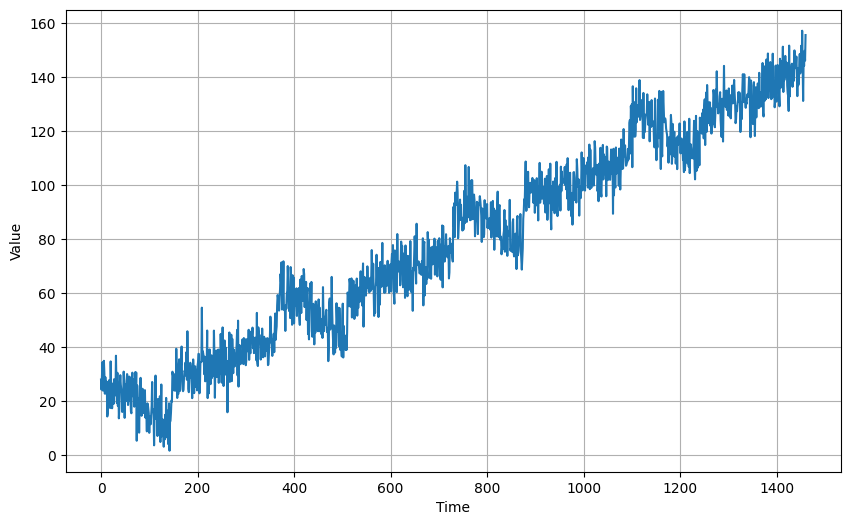

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

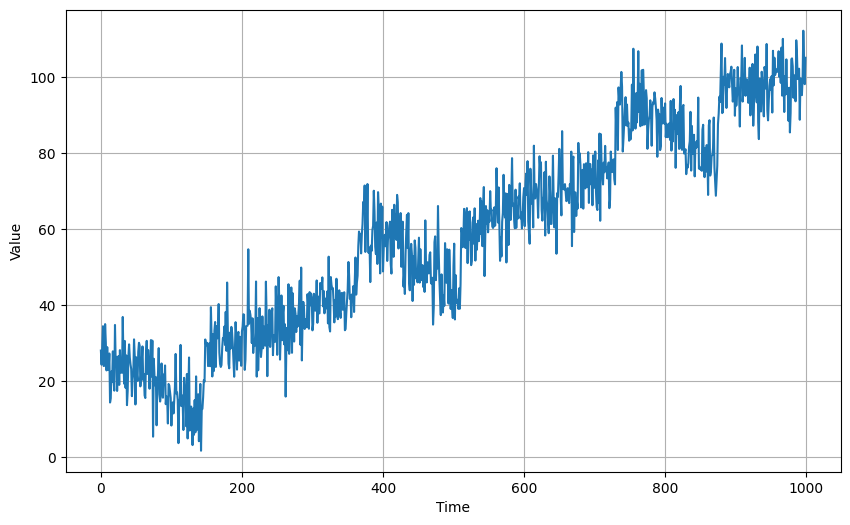

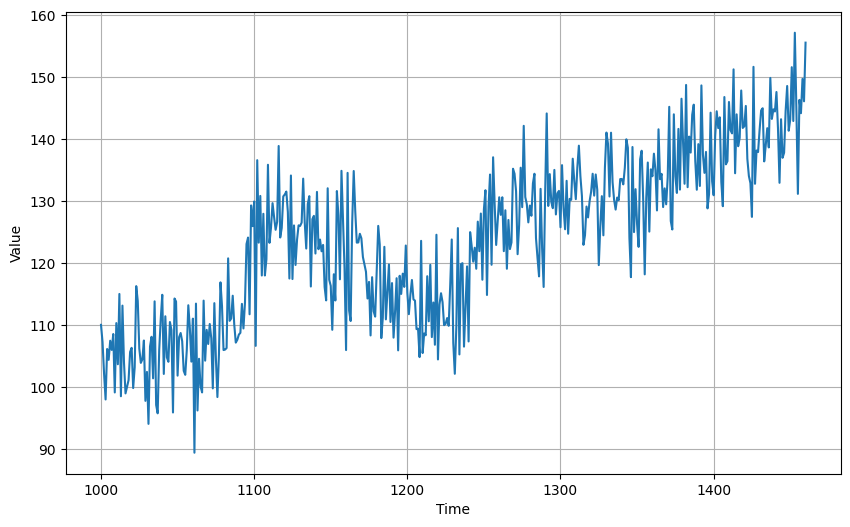

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [5]:
naive_forecast = series[split_time - 1:-1]

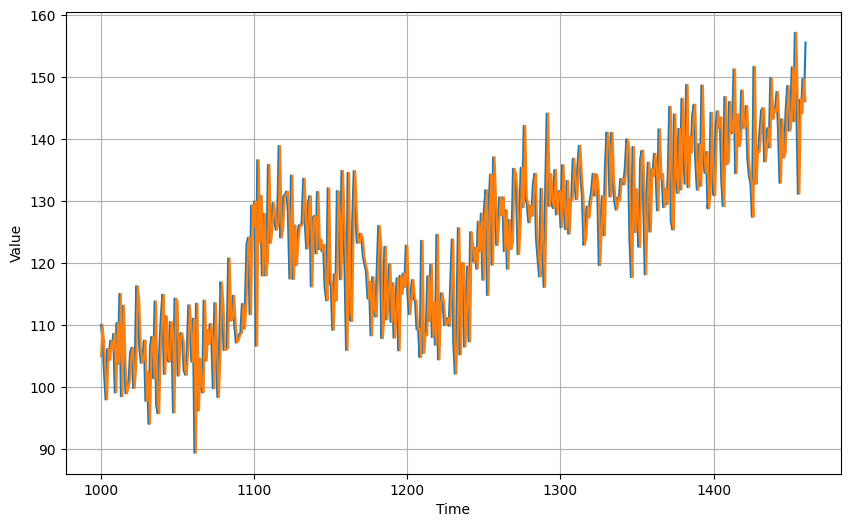

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

## 예측 정확도 측정하기

In [18]:
# 예측 정확도 측정
import tensorflow as tf

# Metric 객체 생성
mse_metric = tf.keras.metrics.MeanSquaredError()
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# 상태 업데이트
mse_metric.update_state(x_valid, naive_forecast)
mae_metric.update_state(x_valid, naive_forecast)

# 결과 출력
print(mse_metric.result().numpy())
print(mae_metric.result().numpy())

2024-08-13 23:43:14.093550: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-13 23:43:14.093603: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-13 23:43:14.093615: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-13 23:43:14.093878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-13 23:43:14.093906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


76.474915
6.8992977


### 이동 평균으로 예측하기

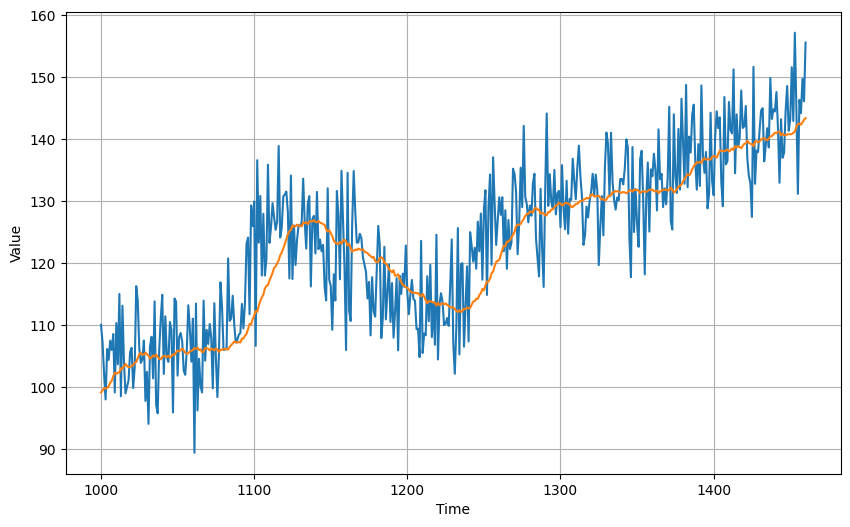

In [19]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
       If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [22]:
# Metric 객체 생성
mse_metric = tf.keras.metrics.MeanSquaredError()
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# 상태 업데이트
mse_metric.update_state(x_valid, moving_avg)
mae_metric.update_state(x_valid, moving_avg)

# 결과 출력
print(mse_metric.result().numpy())
print(mae_metric.result().numpy())

49.04444
5.532835


### 개선된 이동 평균 방법

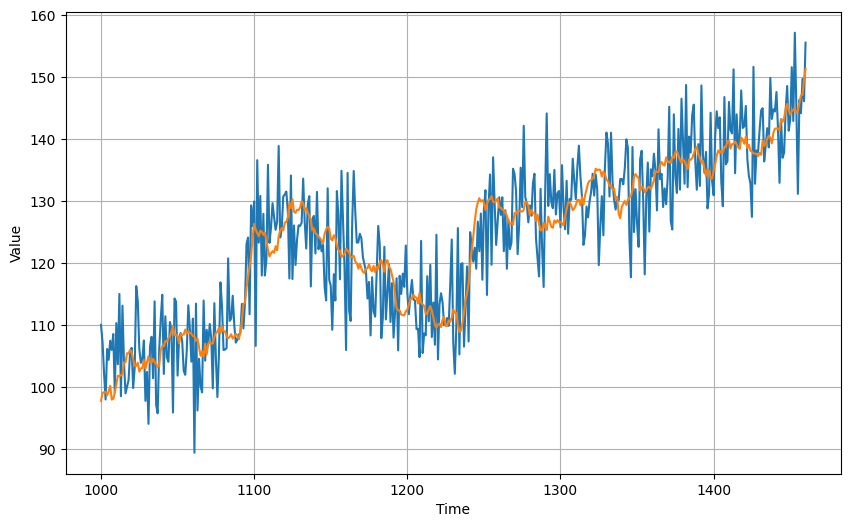

In [23]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
diff_moving_avg = \
    moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

diff_moving_avg_plus_smooth_past = \
    moving_average_forecast(series[split_time - 370:-360], 10) + \
    diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [24]:
# Metric 객체 생성
mse_metric = tf.keras.metrics.MeanSquaredError()
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# 상태 업데이트
mse_metric.update_state(x_valid, diff_moving_avg_plus_smooth_past)
mae_metric.update_state(x_valid, diff_moving_avg_plus_smooth_past)

# 결과 출력
print(mse_metric.result().numpy())
print(mae_metric.result().numpy())

40.902336
5.1360006
